In [36]:
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

import emoji


# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Sklearn
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (train_test_split, GridSearchCV, KFold,
                                     StratifiedKFold, cross_validate, cross_val_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# Explainer
import lime
import shap

#pkl
import joblib





## Positive Class: r/depression Posts

In [2]:
#Load submissions data
df_pos = pd.read_csv('data/Depression.csv')
df_pos['text_data'] = df_pos['title'].fillna('') + ' ' + df_pos['text'].fillna('')
df_pos['date_raw'] = pd.to_datetime(df_pos['created_utc'], unit='s')
df_pos['date'] = df_pos['date_raw'].dt.date
df_pos.head()

,title,num_comments,text,id,author,created_utc,score,upvote_ratio,url,flair,disorder,text_data,date_raw,date
0,Im calling it,0,Its alot more complicated but esntially i have...,13wan0q,HemloknessMonster,1.685503e+09,1,1.0,https://www.reddit.com/r/depression/comments/1...,NaN,Depression,Im calling it Its alot more complicated but es...,2023-05-31 03:10:53,2023-05-31
1,I’m worried depressed partner is staying with ...,0,Every time something stressful comes up he tri...,13wam26,owmyankles,1.685503e+09,1,1.0,https://www.reddit.com/r/depression/comments/1...,NaN,Depression,I’m worried depressed partner is staying with ...,2023-05-31 03:09:37,2023-05-31
2,killing myself tomorrow,3,"I really am fucking done. People suck, I hate ...",13waejs,dogtemple3,1.685502e+09,2,1.0,https://www.reddit.com/r/depression/comments/1...,NaN,Depression,killing myself tomorrow I really am fucking do...,2023-05-31 03:00:06,2023-05-31
3,Don’t have too many good memories,0,"Hello,\n\nI’m 26 and I’m sitting here kinda sa...",13wad8o,Rich_Construction_85,1.685502e+09,1,1.0,https://www.reddit.com/r/depression/comments/1...,NaN,Depression,"Don’t have too many good memories Hello,\n\nI’...",2023-05-31 02:58:24,2023-05-31
4,On a string or something,0,"""I need to put us on hold.""\r \nHe said that ...",13wa9cq,A10p99,1.685502e+09,1,1.0,https://www.reddit.com/r/depression/comments/1...,NaN,Depression,"On a string or something ""I need to put us on ...",2023-05-31 02:53:08,2023-05-31


In [3]:
df_pos.shape

(1971, 14)

In [4]:
#Filter columns
df_pos = df_pos[['date', 'id','text_data']]
df_pos['Depression Risk'] = True
df_pos.head()

,date,id,text_data,Depression Risk
0,2023-05-31,13wan0q,Im calling it Its alot more complicated but es...,True
1,2023-05-31,13wam26,I’m worried depressed partner is staying with ...,True
2,2023-05-31,13waejs,killing myself tomorrow I really am fucking do...,True
3,2023-05-31,13wad8o,"Don’t have too many good memories Hello,\n\nI’...",True
4,2023-05-31,13wa9cq,"On a string or something ""I need to put us on ...",True


In [5]:
# remove random rows from r/depression so that the data would be balanced

remove_n = 1971-1956
drop_indices = np.random.choice(df_pos.index, remove_n, replace=False)
df_pos = df_pos.drop(drop_indices)

In [6]:
# postive class is now equal to negative class

df_pos.shape[0]

1956

## Negative Class: r/randomthoughts posts

In [7]:
# data from r/randomthoughts
df_neg = pd.read_csv('data/Randomthoughts.csv')

# Add new columns
df_neg['text_data'] = df_neg['title'].fillna('') + ' ' + df_neg['text'].fillna('')
df_neg['date_raw'] = pd.to_datetime(df_neg['created_utc'], unit='s')
df_neg['date'] = df_neg['date_raw'].dt.date
df_neg['Depression Risk'] = False
df_neg.head()

,title,num_comments,text,id,author,created_utc,score,upvote_ratio,url,flair,disorder,text_data,date_raw,date,Depression Risk
0,Assholes blasting their music for everyone to ...,1,"Sitting in front of a dingus right now, passiv...",13y9p5p,Mugwumpen,1.685704e+09,1,1.0,https://www.reddit.com/r/RandomThoughts/commen...,NaN,Randomthoughts,Assholes blasting their music for everyone to ...,2023-06-02 11:10:40,2023-06-02,False
1,Being nice isn't always kind,1,NaN,13y9ov9,jackal_lynn,1.685704e+09,1,1.0,https://www.reddit.com/r/RandomThoughts/commen...,NaN,Randomthoughts,Being nice isn't always kind,2023-06-02 11:10:17,2023-06-02,False
2,We are officially closer to 2040 than 2006,1,This was posted at 12:00pm UK time on June 2nd...,13y9hwb,23aviators,1.685704e+09,2,1.0,https://www.reddit.com/r/RandomThoughts/commen...,NaN,Randomthoughts,We are officially closer to 2040 than 2006 Thi...,2023-06-02 11:00:18,2023-06-02,False
3,Does animal abuse count if it’s directed towar...,2,NaN,13y97fb,AverageOxygenUser,1.685703e+09,1,1.0,https://www.reddit.com/r/RandomThoughts/commen...,NaN,Randomthoughts,Does animal abuse count if it’s directed towar...,2023-06-02 10:44:15,2023-06-02,False
4,There's a huge market for flavored breakfast c...,2,NaN,13y8tt1,ZootOfCastleAnthrax,1.685701e+09,1,1.0,https://www.reddit.com/r/RandomThoughts/commen...,NaN,Randomthoughts,There's a huge market for flavored breakfast c...,2023-06-02 10:23:16,2023-06-02,False


In [8]:
#Filter Columns
df_neg = df_neg[['date', 'id', 'text_data', 'Depression Risk']]
df_neg.head()

,date,id,text_data,Depression Risk
0,2023-06-02,13y9p5p,Assholes blasting their music for everyone to ...,False
1,2023-06-02,13y9ov9,Being nice isn't always kind,False
2,2023-06-02,13y9hwb,We are officially closer to 2040 than 2006 Thi...,False
3,2023-06-02,13y97fb,Does animal abuse count if it’s directed towar...,False
4,2023-06-02,13y8tt1,There's a huge market for flavored breakfast c...,False


## Combined DataFrame: postive class (r/depression) + negative class (r/randomthoughts)

In [9]:
df_combined = pd.concat([df_pos, df_neg])
df_combined['text_data'] = df_combined['text_data'].str.lower()
df_combined

,date,id,text_data,Depression Risk
0,2023-05-31,13wan0q,im calling it its alot more complicated but es...,True
1,2023-05-31,13wam26,i’m worried depressed partner is staying with ...,True
2,2023-05-31,13waejs,killing myself tomorrow i really am fucking do...,True
3,2023-05-31,13wad8o,"don’t have too many good memories hello,\n\ni’...",True
4,2023-05-31,13wa9cq,"on a string or something ""i need to put us on ...",True
...,...,...,...,...
1951,2022-07-11,vw7ur2,whatever happened to live and let live?,False
1952,2022-05-03,uh9c9w,what if american women went on “strike”? like ...,False
1953,2021-08-20,p7rp97,what if colors look completely different to ev...,False
1954,2023-04-14,12m69s1,[mod post]] hey /r/randomthoughts! as some of ...,False


In [10]:
# check in case of imbalanced data

print(df_combined['Depression Risk'].value_counts())
print(df_combined.shape)

True     1956
False    1956
Name: Depression Risk, dtype: int64
(3912, 4)


## Data Cleaning

In [11]:
def expand_contractions(text):
    result = text
    
    contractions = {
        "ain't": "am not / are not",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had / he would",
        "he'd've": "he would have",
        "he'll": "he shall / he will",
        "he'll've": "he shall have / he will have",
        "he's": "he has / he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has / how is",
        "i'd": "I had / I would",
        "i'd've": "I would have",
        "i'll": "I shall / I will",
        "i'll've": "I shall have / I will have",
        "i'm": "I am",
        "i've": "I have",
        "isn't": "is not",
        "it'd": "it had / it would",
        "it'd've": "it would have",
        "it'll": "it shall / it will",
        "it'll've": "it shall have / it will have",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had / she would",
        "she'd've": "she would have",
        "she'll": "she shall / she will",
        "she'll've": "she shall have / she will have",
        "she's": "she has / she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as / so is",
        "that'd": "that would / that had",
        "that'd've": "that would have",
        "that's": "that has / that is",
        "there'd": "there had / there would",
        "there'd've": "there would have",
        "there's": "there has / there is",
        "they'd": "they had / they would",
        "they'd've": "they would have",
        "they'll": "they shall / they will",
        "they'll've": "they shall have / they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had / we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall / what will",
        "what'll've": "what shall have / what will have",
        "what're": "what are",
        "what's": "what has / what is",
        "what've": "what have",
        "when's": "when has / when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has / where is",
        "where've": "where have",
        "who'll": "who shall / who will",
        "who'll've": "who shall have / who will have",
        "who's": "who has / who is",
        "who've": "who have",
        "why's": "why has / why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had / you would",
        "you'd've": "you would have",
        "you'll": "you shall / you will",
        "you'll've": "you shall have / you will have",
        "you're": "you are",
        "you've": "you have"
    }
    
    for word in result.split():
        if word in contractions:
            result = result.replace(word, contractions[word])

    return result

In [12]:
import unicodedata

def remove_accents(text):
    return ''.join(char for char in unicodedata.normalize('NFD', text)
                   if unicodedata.category(char) != 'Mn')

In [13]:
def remove_emoji(text):
    return emoji.replace_emoji(text)

In [14]:
def remove_hashtags(text):
    return re.sub(r'[＃#](\s\w+)', " ", text)

In [15]:
def remove_mentions(text):
    return re.sub('@([a-zA-Z0-9]{1,15})', ' ', text)

In [16]:
def remove_hyperlinks(text):
    return re.sub('<[^>]+>', ' ', text)

In [17]:
def remove_links(text):
    return re.sub('https://', "", text)

In [18]:
def remove_numbers(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [19]:
def remove_extra_white_spaces(text):
    return re.sub('\s+', ' ', text)

In [20]:
def remove_low_quality_words(x):
    
    lst = list()
    
    for i in x.split():
        if len(i) > 2:
            if len(i) < 30:
                if len(set(i)) > 2:
                    lst.append(i)
                    
    return " ".join(lst)

In [21]:
cleaning_functions = [
    remove_links,
    expand_contractions,
    remove_accents,
    remove_emoji, 
    remove_hashtags, 
    remove_mentions,
    remove_hyperlinks,
    remove_numbers,
    remove_extra_white_spaces,
    remove_low_quality_words
]


In [22]:
import spacy

'''
Text Processing Functions
'''
nlp = spacy.load('en_core_web_lg')

def tokenize_and_lemmatize(text):
    doc = nlp(text)

    li = []
    for token in doc:
        li.append(token.lemma_)

    return " ".join(li)

In [23]:
clean_df = df_combined.copy()

# Clean the Text
for func in cleaning_functions:
    clean_df['text_data'] = clean_df.apply(lambda x: func(x['text_data']), axis=1)

# Tokenize and Lemmatize
clean_df['text_data'] = clean_df.apply(lambda x: tokenize_and_lemmatize(x['text_data']), axis=1)


clean_df.head()

,date,id,text_data,Depression Risk
0,2023-05-31,13wan0q,call its alot more complicated but esntially h...,True
1,2023-05-31,13wam26,worry depressed partner stay with because does...,True
2,2023-05-31,13waejs,kill myself tomorrow really fuck do people suc...,True
3,2023-05-31,13wad8o,don have many good memory hello and sit here k...,True
4,2023-05-31,13wa9cq,stre something need put hold say that how long...,True


In [ ]:
# clean_df.to_csv('depression_clean.csv', index = False)

Mapping

In [24]:
sentiment_map = {
    True: 1,
    False: 0
}

sentiment_map_reverse = {
    0: False,
    1: True
}
clean_df['Sentiment'] = clean_df['Depression Risk'].map(sentiment_map)


Would Recommend:          0
True   1956
False  1956
Proportion Chance Criterion: 50.00%
1.25 * Proportion Chance Criterion: 62.50%


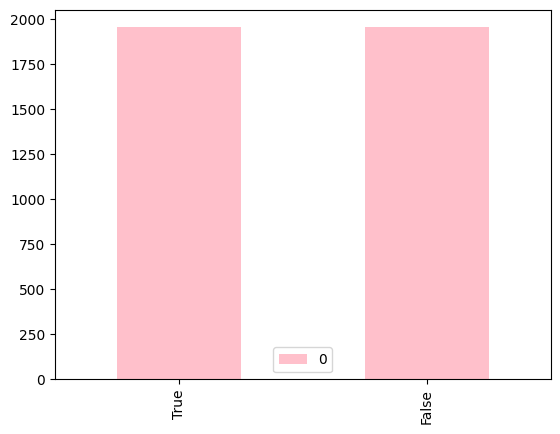

In [25]:
# Compute the PCC

state_counts = Counter(clean_df['Depression Risk'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

## Split to Train and Test Datasets

In [27]:
# split data into training and testing set

X = clean_df['text_data']
y = clean_df['Sentiment']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=42, test_size=0.25,
                                                                  stratify=y)



## Apply TfidfVecorizer to Texts to Generate Features

In [28]:

tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

# Convert Training data into Vector with TfIdf Scores
X_trainval_cv = tfidf.fit_transform(X_trainval)
X_holdout_cv = tfidf.transform(X_holdout)

In [29]:
X_trainval_cv

<2934x86934 sparse matrix of type '<class 'numpy.float64'>'
	with 194208 stored elements in Compressed Sparse Row format>

In [30]:
# convert tfidf results to a dataframe for checking

feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(X_trainval_cv.toarray()).flatten()[::-1]

tfidf_vects = pd.DataFrame(X_trainval_cv.toarray(), columns=feature_array)

In [31]:
tfidf_vects

,aaron,aaron taylor,abalados,abalados com,abandon,abandon birthday,abandon care,abandon constantly,abandon course,abandon crew,...,zone peer,zone speak,zone stay,zone stuff,zoning,zoning feel,zoom,zoom like,zoomie,zoomie just
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# check values of one column/feature

tfidf_vects['feel'].sort_values(ascending=False)

1518    0.301596
328     0.265862
573     0.252479
1590    0.222586
2250    0.218300
          ...   
1158    0.000000
1159    0.000000
1160    0.000000
1161    0.000000
2933    0.000000
Name: feel, Length: 2934, dtype: float64

# Train Models

# Baseline Models

In [49]:
# AutoML for Baseline Models

def auto_ml(X, y, models_dict):

    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []
        
        train_prec =[]
        val_prec =[]

        train_f1 =[]
        val_f1 =[]

        start_time = time.time()

        # fit
        model.fit(X_trainval_cv, y_trainval)

        # predict
        train_preds = model.predict(X_trainval_cv)
        val_preds = model.predict(X_holdout_cv)
        
        ################# this portion can be edited ###############

        # classification accuracy
        train_scores.append(model.score(X_trainval_cv, y_trainval))
        val_scores.append(model.score(X_holdout_cv, y_holdout))

        # recall
        train_recall.append(recall_score(y_trainval, train_preds))
        val_recall.append(recall_score(y_holdout, val_preds))
        
        # precision
        train_prec.append(precision_score(y_trainval, train_preds))
        val_prec.append(precision_score(y_holdout, val_preds))

        # f1
        train_f1.append(f1_score(y_trainval, train_preds))
        val_f1.append(f1_score(y_holdout, val_preds))

        end_time = time.time()

        results[model_name] = {
            'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
            'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
            'Train Recall': np.round(np.mean(train_recall) * 100, 2),
            'Val Recall': np.round(np.mean(val_recall) * 100, 2),
            'Train Precision': np.round(np.mean(train_prec) * 100, 2),
            'Val Precision': np.round(np.mean(val_prec) * 100, 2),
            'Train F1': np.round(np.mean(train_f1) * 100, 2),
            'Val F1': np.round(np.mean(val_f1) * 100, 2),
            'Mean Cross_Val_F1_Score': np.round(np.mean(cross_val_score(model, X_trainval_cv, y_trainval, cv=5, scoring='f1')) * 100, 2),
            'Run Time': end_time - start_time
        }

        results2[model_name] = {
            'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
            'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
            'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
            'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
            'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec) * 100, 2)),
            'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec) * 100, 2)),
            'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
            'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
            'Mean Cross_Val_F1_Score': np.round(np.mean(cross_val_score(model, X_trainval_cv, y_trainval, cv=5, scoring='f1')) * 100, 2),
            'Run Time': end_time - start_time
        }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

In [50]:
#ML models
models_dict = {
    'LogisticRegressor': LogisticRegression(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'ADABoostClassifier': AdaBoostClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42),
    'SVC': SVC(random_state=42)    
}

In [51]:
auto_run = auto_ml(X_trainval_cv, y_trainval, models_dict)
auto_run[1]

  0%|          | 0/6 [00:00<?, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1,Val F1,Mean Cross_Val_F1_Score,Run Time
LogisticRegressor,96.69%,89.78%,95.91%,94.68%,97.44%,86.22%,96.67%,90.25%,88.43,0.810185
RandomForestClassifier,100.00%,88.14%,100.00%,85.07%,100.00%,90.63%,100.00%,87.76%,86.42,10.828763
GradientBoostingClassifier,92.64%,87.83%,89.98%,86.30%,95.03%,89.03%,92.44%,87.64%,88.29,17.366099
ADABoostClassifier,91.75%,87.73%,90.46%,87.93%,92.86%,87.58%,91.64%,87.76%,88.2,2.775249
XGBoost,99.05%,89.26%,98.09%,91.21%,100.00%,87.80%,99.04%,89.47%,89.43,4.188725
SVC,99.76%,90.49%,100.00%,94.48%,99.53%,87.50%,99.76%,90.86%,88.48,9.831931


# Hypertuning for XGBoost (scoring: f1 score)

In [57]:
# Set scaler
scaler = MinMaxScaler()

# Initialize model
model = XGBClassifier()

# Initialize cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize pipeline
pipeline = Pipeline ([("scaler", scaler),("xg", model)]) 

In [58]:
# Set parameter values
n_estimators = [100, 200]
learning_rate = [1.0, 0.1, 0.01]
max_depth = [3, 7]
reg_lambda = [0.1]
min_child_weight = [1, 5]

# Initialize parameters
param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'reg_lambda': reg_lambda,
    'min_child_weight': min_child_weight
}


In [59]:
# test different n_jobs values

model_grid_search_xg = GridSearchCV(model, param_grid, verbose = 1, cv = cv, n_jobs = -1, scoring='f1') 
model_grid_search_xg.fit(X_trainval_cv, y_trainval)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [1.0, 0.1, 0.01], 'max_depth': [3, 7],
                         'min_child_weight': [1, 5], 'n_estimators': [100, 200],
                         'reg_lambda': [0.1]},
             scoring='f1', verbose=1)

In [62]:
# Get best params and f1 scores

print(f"Best hyperparameters: {model_grid_search_xg.best_params_}")
print(f"Train best f1 score: {model_grid_search_xg.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search_xg.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 0.1}
Train best f1 score: 0.902761
Train best score std: 0.0211336


In [63]:
# View test f1 score

test_score = model_grid_search_xg.score(X_holdout_cv, y_holdout)
print(f"Test best f1 score: {test_score:0.6}")

Test best f1 score: 0.896482


In [98]:
# Access the best hyperparameters
best_params = model_grid_search_xg.best_params_

# Create a new instance of your model with the best hyperparameters
xg_best_model = XGBClassifier(**best_params)


Results

In [99]:
xg_y_pred = xg_best_model.fit(X_trainval_cv, y_trainval).predict(X_holdout_cv)

In [101]:
# Metrics

model_names = ['XG']
for i,y_pred in enumerate([xg_y_pred]):
    print('-------------------------------------------------------------')
    print(model_names[i])
    print(classification_report(y_holdout,xg_y_pred,\
                                target_names=["False", "True"]))

-------------------------------------------------------------
XG
              precision    recall  f1-score   support

       False       0.91      0.88      0.89       489
        True       0.88      0.91      0.90       489

    accuracy                           0.89       978
   macro avg       0.90      0.89      0.89       978
weighted avg       0.90      0.89      0.89       978



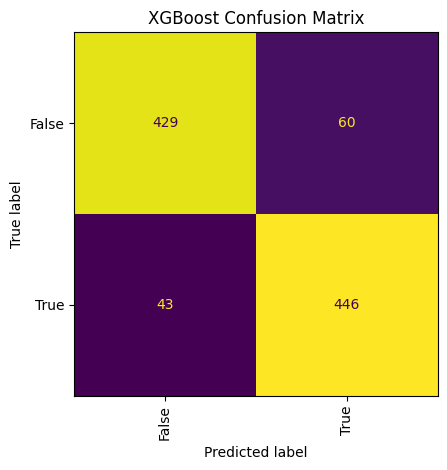

In [103]:
# Confusion Matrix

model_names = ['XG']
for i,y_pred in enumerate([xg_y_pred]):
    cm = confusion_matrix(y_holdout, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=["False", "True"])
    cmd.plot(xticks_rotation=90, colorbar=False)
    plt.title('XGBoost Confusion Matrix')
plt.tight_layout()


Save the model

In [104]:
# Model only

pickle.dump(xg_best_model, open('xgboost.pkl', 'wb'))


In [105]:
# Model + Vectorizer

with open('xgboost_with_vectorizer.pkl', 'wb') as f:
       pickle.dump((tfidf, xg_best_model), f)
    

# Testing the Model

In [106]:
def predictor (text):
    for func in cleaning_functions:
        text = func(text)
    text = tokenize_and_lemmatize(text)
    text_cv = tfidf.transform([text])
    return xg_best_model.predict(text_cv), xg_best_model.predict_proba(text_cv)

In [107]:
text1 = "i want to end your life."
predictor(text1)

(array([1]), array([[0.04658103, 0.95341897]], dtype=float32))

In [108]:
text2 = "I like dogs."
predictor(text2)


(array([0]), array([[0.9611897 , 0.03881031]], dtype=float32))

In [109]:
text3 = "Please stop cutting yourself, it's not worth it"
predictor(text3)

(array([0]), array([[0.90435016, 0.09564982]], dtype=float32))

In [110]:
text4 = "I went to the hospital to have a regular check up."
predictor(text4)


(array([0]), array([[0.9827618, 0.0172382]], dtype=float32))

In [111]:
text5 = "I like to cut myself just to feel something."
predictor(text5)

(array([1]), array([[0.09862596, 0.90137404]], dtype=float32))

In [112]:
# Post from r/MentalHealthPH

text6 = '''
Minsan uupo ako and stare sa kung saan tapos mapapansin ko mag iisang oras na pala akong nakatulala.
May times na okay naman ako then meron sudden burst of sadness na gusto ko iiyak kahit nasa labas ako. Minsan gusto ko nalang maglaho.
I tried reaching out to a Psychologist pero ako yung tinatanong niya kung anong solution ang naiisip ko para maging okay ako. 
Kung alam ko hindi na sana ako nag reach out sa kanila..
'''


predictor(text6)

(array([0]), array([[0.95518804, 0.04481198]], dtype=float32))

In [113]:
# Post from r/MentalHealthPH

text7 = '''
Hi guys normal lang ba yung sobrang bilis ng tibok ng puso at malamig kamay at paa 4am ako nagising hindi na ako nakatulog kasi hanggang ngayon lakas pa rin :(
'''

predictor(text7)

(array([0]), array([[0.9303984 , 0.06960161]], dtype=float32))

In [114]:
# Post from r/MentalHealthPH

text8 = '''Just realized yesterday that I have victim mindset. 
Honestly? Para akong nabunutan ng tinik sa dibdib kasi finally alam ko na mali sakin. 
I feel... Different, parang empowered? Kasi alam ko na yung mga bad things that will happen in the future 'might' not happen. 
I don't know how to articulate my feelings better lol. I hope you can help me find resources on these..
'''

predictor(text8)

(array([1]), array([[0.037552, 0.962448]], dtype=float32))

In [115]:
text9 = "May thoughts ako sometimes na mamamatay ako"
predictor(text9)

(array([0]), array([[0.9827618, 0.0172382]], dtype=float32))

In [116]:
# manually translated text from text9

text10 = "i have thoughts of dying"
predictor(text10)

(array([0]), array([[0.98023033, 0.01976969]], dtype=float32))

In [117]:
text11 = "i feel like dying"
predictor(text11)

(array([0]), array([[0.60506666, 0.3949333 ]], dtype=float32))

In [118]:
text12 = "i feel alive"
predictor(text12)

(array([0]), array([[0.68099326, 0.31900674]], dtype=float32))

In [119]:
text13 = "i feel happy"
predictor(text13)

(array([0]), array([[0.7223282, 0.2776718]], dtype=float32))

# Explainability and Feature Importance for XGBoost

In [136]:
# SHAP explainer

explainer = shap.Explainer(xg_best_model, feature_names=tfidf_vects.columns)
shap_values = explainer(X_trainval_cv)


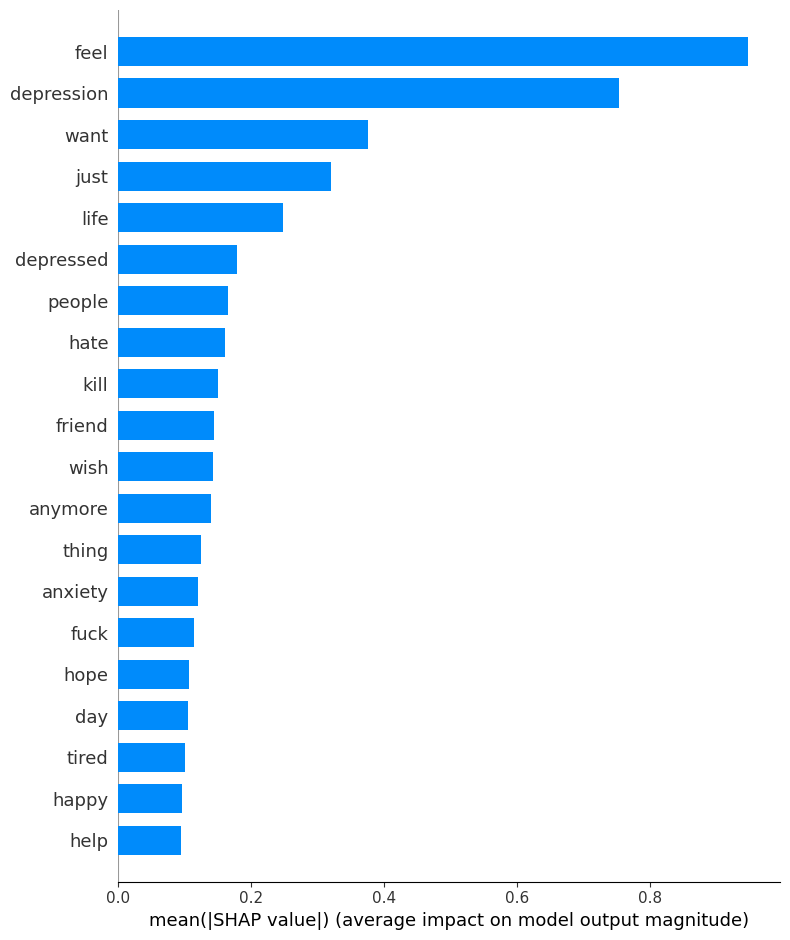

In [139]:
shap.summary_plot(shap_values, X_trainval_cv, plot_type='bar')

In [144]:
# Feature Importance

importance_scores = xg_best_model.feature_importances_
feature_names = tfidf.get_feature_names_out()


In [174]:
sorted_features = sorted(zip(importance_scores, feature_names), reverse=True)

feature_importance_df = pd.DataFrame(columns=["Feature", "Importance Score"])

for score, feature in sorted_features:
    feature_importance_df = feature_importance_df.append({"Feature": feature, "Importance Score": score}, ignore_index=True)




In [175]:
feature_importance_df.head(15)


,Feature,Importance Score
0,feel,0.051292
1,depression,0.040316
2,want,0.016142
3,depressed,0.014878
4,lose,0.012069
5,anymore,0.011808
6,tired,0.009522
7,work,0.009507
8,life,0.008410
9,suicide,0.008294
